<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Taxi Tip Prediction using Scikit-Learn and Snap ML**


Estimated time needed: **30** minutes


In this exercise session you will consolidate your machine learning (ML) modeling skills by using a popular regression model: Decision Tree. You will use a real dataset to train such a model. The dataset includes information about taxi tip and was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). You will use the trained model to predict the amount of tip paid. 

In the current exercise session, you will practice not only the Scikit-Learn Python interface, but also the Python API offered by the Snap Machine Learning (Snap ML) library. Snap ML is a high-performance IBM library for ML modeling. It provides highly-efficient CPU/GPU implementations of linear models and tree-based models. Snap ML not only accelerates ML algorithms through system awareness, but it also offers novel ML algorithms with best-in-class accuracy. For more information, please visit https://www.zurich.ibm.com/snapml/.


## Objectives


After completing this lab you will be able to:


* Perform basic data preprocessing using Scikit-Learn
* Model a regression task using the Scikit-Learn and Snap ML Python APIs
* Train a Decision Tree Regressor model using Scikit-Learn and Snap ML
* Run inference and assess the quality of the trained models


## Table of Contents


<div class="alert alert-block alert-info" style="margin-top: 10px">
    <ol>
        <li><a href="#introduction">Introduction</a></li>
        <li><a href="#import_libraries">Import Libraries</a></li>
        <li><a href="#dataset_analysis">Dataset Analysis</a></li>
        <li><a href="#dataset_preprocessing">Dataset Preprocessing</a></li>
        <li><a href="#dataset_split">Dataset Train/Test Split</a></li>
        <li><a href="#dt_sklearn">Build a Decision Tree Regressor model with Scikit-Learn</a></li>
        <li><a href="#dt_snap">Build a Decision Tree Regressor model with Snap ML</a></li>
        <li><a href="#dt_sklearn_snap">Evaluate the Scikit-Learn and Snap ML Decision Tree Regressors</a></li>
    </ol>
</div>
<br>
<hr>


<div id="Introduction">
    <h2>Introduction</h2>
    <br>The dataset used in this exercise session is publicly available here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page (all rights reserved by Taxi & Limousine Commission(TLC), City of New York). The TLC Yellow Taxi Trip Records of June, 2019 are used in this notebook. The prediction of the tip amount can be modeled as a regression problem. To train the model you can use part of the input dataset and the remaining data can be used to assess the quality of the trained model. First, let's download the dataset.
    <br>
</div>


In [2]:
# download June 2020 TLC Yellow Taxi Trip records
!wget -nc https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv 

File ‘yellow_tripdata_2019-06.csv’ already there; not retrieving.



In [3]:
# download June 2020 TLC Yellow Taxi Trip records
# Uncomment the next line, if working locally
#!curl https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv 

<div id="import_libraries">
    <h2>Import Libraries</h2>
</div>


In [4]:
# Snap ML is available on PyPI. To install it simply run the pip command below.
!pip install snapml==1.8.2

In [5]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


<div id="dataset_analysis">
    <h2>Dataset Analysis</h2>
</div>


In this section you will read the dataset in a Pandas dataframe and visualize its content. You will also look at some data statistics.

Note: A Pandas dataframe is a two-dimensional, size-mutable, potentially heterogeneous tabular data structure. For more information: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html.


In [6]:
# read the input data
raw_data = pd.read_csv('yellow_tripdata_2019-06.csv')
print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

# display first rows in the dataset
raw_data.head(1)

There are 3936004 observations in the dataset.
There are 18 variables in the dataset.


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.0,0.0,0.3,4.3,0.0


Each row in the dataset represents a taxi trip. As shown above, each row has 18 variables. One variable is called tip_amount and represents the target variable. Your objective will be to train a model that uses the other variables to predict the value of the tip_amount variable. Let's first clean the dataset and retrieve basic statistics about the target variable.


There are 2712719 observations in the dataset.
There are 17 variables in the dataset.


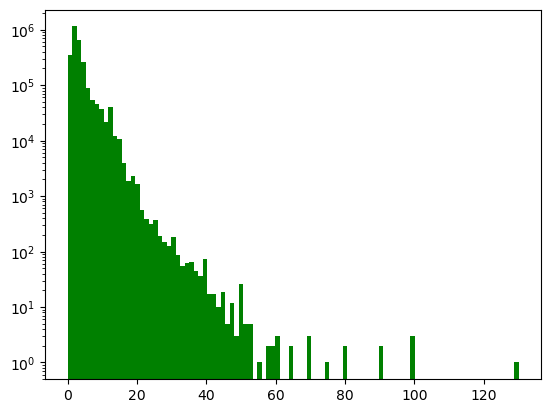

Minimum amount value is  0.01
Maximum amount value is  130.0
90% of the trips have a tip amount less or equal than  5.95


In [7]:
# some trips report 0 tip. it is assumed that these tips were paid in cash.
# for this study we drop all these rows
'''Clever, keep this inmind for final project: inherent problems with data.'''
raw_data = raw_data[raw_data['tip_amount'] > 0]

# we also remove some outliers, namely those where the tip was larger than the fare cost
'''why? could this not be the result of a patern we could discover?'''
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

# we remove trips with very large fare cost
raw_data = raw_data[((raw_data['fare_amount'] >=2) & (raw_data['fare_amount'] < 200))]

# we drop variables that include the target variable in it, namely the total_amount
clean_data = raw_data.drop(['total_amount'], axis=1)

# release memory occupied by raw_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
#del raw_data
gc.collect()

# print the number of trips left in the dataset
print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("There are " + str(len(clean_data.columns)) + " variables in the dataset.")

plt.hist(clean_data.tip_amount.values, 100, histtype='bar', facecolor='g')
'''look at this.... *BOOM* and now its log!'''
plt.yscale("log")
plt.show()

print("Minimum amount value is ", np.min(clean_data.tip_amount.values))
print("Maximum amount value is ", np.max(clean_data.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(clean_data.tip_amount.values, 90))

In [8]:
# display first rows in the dataset
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


By looking at the dataset in more detail, we see that it contains information such as pick-up and drop-off dates/times, pick-up and drop-off locations, payment types, driver-reported passenger counts etc. Before actually training a ML model, we will need to preprocess the data. We need to transform the data in a format that will be correctly handled by the models. For instance, we need to encode the categorical features.


<div id="dataset_preprocessing">
    <h2>Dataset Preprocessing</h2>
</div>


In this subsection you will prepare the data for training. 


In [9]:

# Convert 'tpep_dropoff_datetime' and 'tpep_pickup_datetime' columns to datetime objects
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])

# Extract pickup and dropoff hour
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

# Extract pickup and dropoff day of the week (0 = Monday, 6 = Sunday)
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

# Calculate trip time in seconds
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).dt.total_seconds()

# Ideally use the full dataset for this exercise.
# However, if you run into out-of-memory issues due to the data size, reduce it.
# For instance, in this example, we use only the first 200,000 samples.
first_n_rows = 200000
clean_data = clean_data.head(first_n_rows)

In [10]:
# drop the pickup and dropoff datetimes
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# some features are categorical, we need to encode them
# to encode them we use one-hot encoding from the Pandas package
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_data, columns = get_dummy_col)

# release memory occupied by clean_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del clean_data
gc.collect()

19524

In [11]:
# extract the labels from the dataframe
y = proc_data[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)

# get the feature matrix used for training
X = proc_data.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (200000, 517) y.shape= (200000, 1)


<div id="dataset_split">
    <h2>Dataset Train/Test Split</h2>
</div>


Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (140000, 517) Y_train.shape= (140000, 1)
X_test.shape= (60000, 517) Y_test.shape= (60000, 1)


<div id="dt_sklearn">
    <h2>Build a Decision Tree Regressor model with Scikit-Learn</h2>
</div>


In [13]:
# import the Decision Tree Regression Model from scikit-learn
from sklearn.tree import DecisionTreeRegressor

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

# train a Decision Tree Regressor using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  8.39466


<div id="dt_snapml">
    <h2>Build a Decision Tree Regressor model with Snap ML</h2>
</div>


In [14]:
# import the Decision Tree Regressor Model from Snap ML
from snapml import DecisionTreeRegressor

# in contrast to sklearn's Decision Tree, Snap ML offers multi-threaded CPU/GPU training 
# to use the GPU, one needs to set the use_gpu parameter to True
# snapml_dt = DecisionTreeRegressor(max_depth=4, random_state=45, use_gpu=True)

# to set the number of CPU threads used at training time, one needs to set the n_jobs parameter
# for reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

# train a Decision Tree Regressor model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  7.78862


<div id="dt_sklearn_snapml">
    <h2>Evaluate the Scikit-Learn and Snap ML Decision Tree Regressor Models</h2>
</div>


In [15]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference using the sklearn model
sklearn_pred = sklearn_dt.predict(X_test)

# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

# run inference using the Snap ML model
snapml_pred = snapml_dt.predict(X_test)

# evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 1.08x 
[Scikit-Learn] MSE score : 1.636
[Snap ML] MSE score : 1.655


As shown above both decision tree models provide the same score on the test dataset. However Snap ML runs the training routine faster than Scikit-Learn. This is one of the advantages of using Snap ML: acceleration of training of classical machine learning models, such as linear and tree-based models. For more Snap ML examples, please visit https://github.com/IBM/snapml-examples. Moreover, as shown above, not only is Snap ML seemlessly accelerating scikit-learn applications, but the library's Python API is also compatible with scikit-learn metrics and data preprocessors.


## Practice


Lets train a `SnapML` `Decision Tree Regressor` with the `max_depth` parameter set to `12`, `random_state` set to `45`, and `n_jobs` set to `4` and compare its Mean Squared Error to the decision tree regressor we trained previously


Start by creating and training the decision tree


In [16]:

""" creating the modle"""
Max_Depth_is_12 = DecisionTreeRegressor(max_depth=12, random_state=45, n_jobs=4)
"""Training it"""
Max_Depth_is_12.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', gpu_id=0, hist_nbins=256, max_depth=12,
           max_features=None, min_samples_leaf=1, n_jobs=4,
           random_state=45, splitter='best', use_gpu=False,
           use_histograms=True, verbose=False)

<details><summary>Click here for the solution</summary>

```python    
tree = DecisionTreeRegressor(max_depth=12, random_state=45, n_jobs=4)

tree.fit(X_train, y_train)

```

</details>


Now calculate the Mean Squared Error on the test data


In [18]:
prediction   = Max_Depth_is_12.predict(X_test)
print("The Mean^2 is", mean_squared_error(y_test,prediction))

The Mean^2 is 1.8691480131558091


We learned that increasing the `max_depth` parameter to `12` increases the MSE


## Authors


Andreea Anghel


### Other Contributors


Sangeeth Keeriyadath 

Joseph Santarcangelo

Azim Hirjani


## Change Log


|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2021-08-31  | 0.1  | AAN  |  Created Lab Content |


 Copyright &copy; 2021 IBM Corporation. This notebook and its source code are released under the terms of the [MIT License](https://cognitiveclass.ai/mit-license/).
